# Problématique 

Code permettant d'entrainer un modèle de reconnaissance text manuscrit.


# Import

In [53]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [54]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)

<module 'rendering' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/rendering.py'>

# Chargement du dataframe

In [55]:
# initialisation des variables globales
rss.init()

In [56]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset()

dataset_train_canny, dataset_test_canny, X_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

In [57]:
# PROPOSITION DB : initialisation d'un iterator pour afficher différents batchs
batch_id=0
iterator = iter(dataset_train)

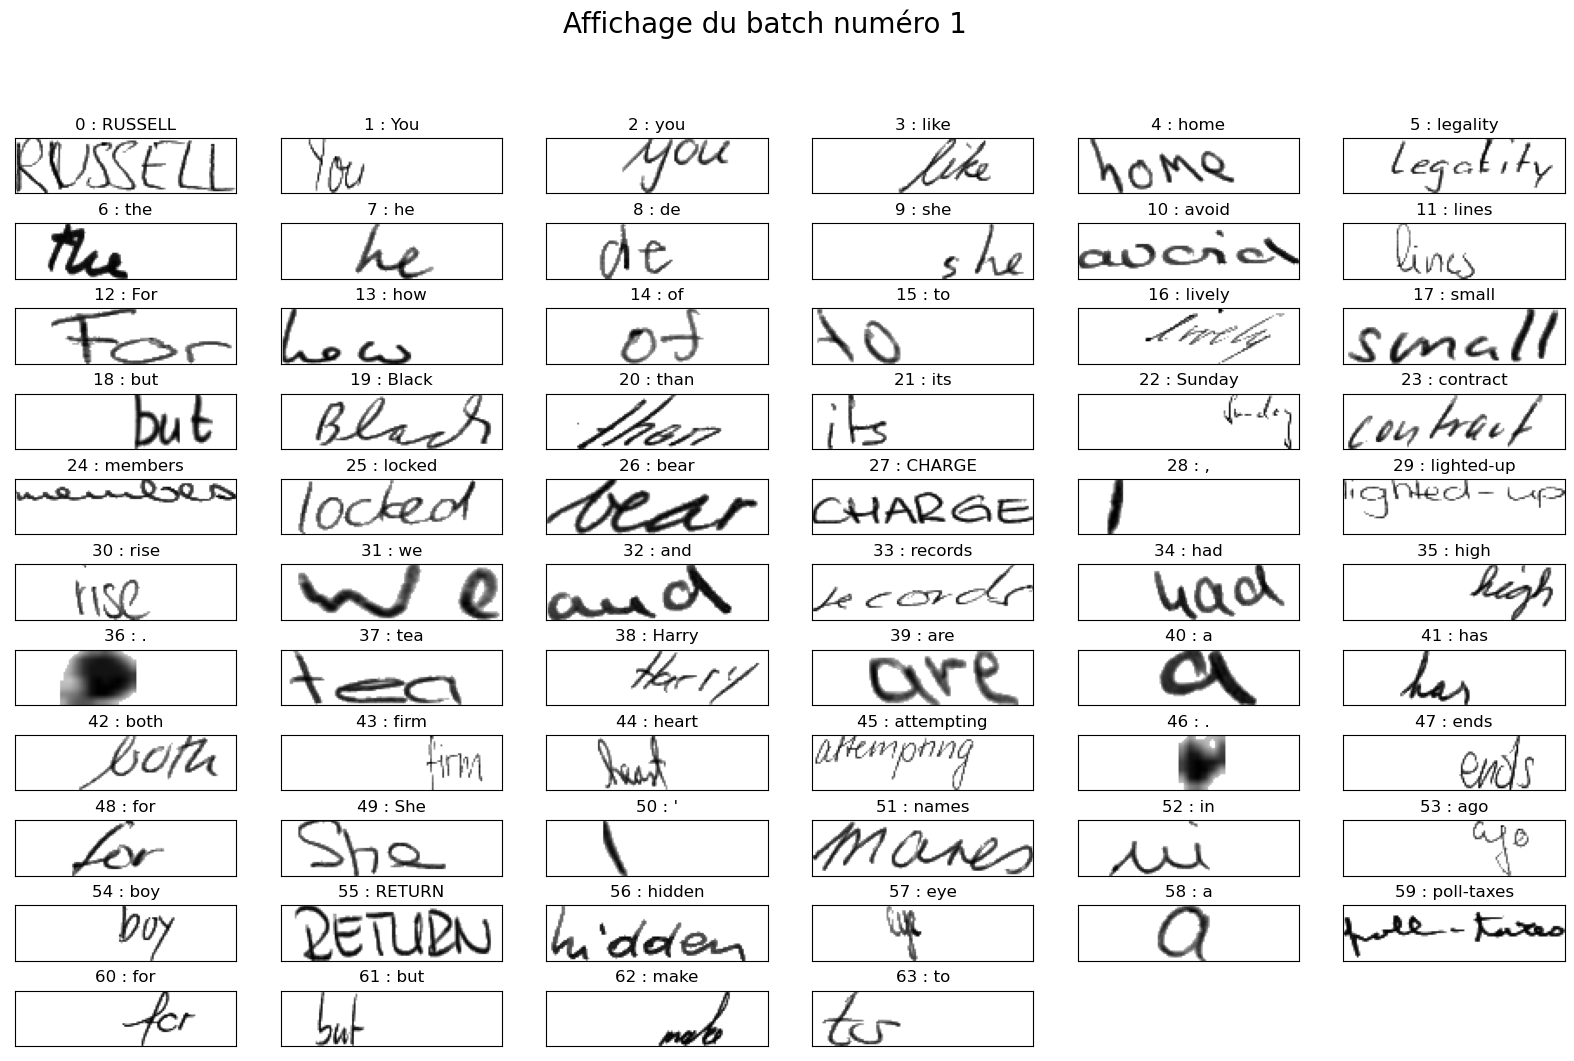

In [58]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement

x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id)

# Model RNN

### Création Modèle

In [59]:
model = mdl.create_modele()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 128, 32)       832       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 128, 32)      128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_6 (Batc  (None, 16, 64, 64)      

In [60]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [61]:
# chargement du model de référence ou nouvel entraintement

new_training = False

if new_training:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=CTCLoss(), optimizer=optimizer)
    history = model.fit(
        dataset_train,
        validation_data=dataset_test,
        callbacks=[
            early_stop_callback,
            checkpoint_callback
        ],
        epochs=10
    )
else:
    model = tf.keras.models.load_model('../pickle/model_db_ref0', custom_objects={"CTCLoss": CTCLoss})


In [58]:
with open('history.pickle', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

with open('history.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)

In [43]:
x, y = next(iter(dataset_train))
x.shape

TensorShape([64, 128, 32, 1])

In [62]:
y_pred = model.predict(dataset_test)


149/149 [==============================] - 67s 442ms/step


In [63]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

[(',', "'"),
 ('th', 'the'),
 ('a', '#'),
 ('befire', 'before'),
 ('aed', 'and'),
 ('.', '.'),
 ('grantly', 'greatly'),
 ('about', 'about'),
 ('this', 'this'),
 ('nifictence', 'confidence')]

In [13]:
# enregistrement du model

model.save('../pickle/model_db_ref0')

INFO:tensorflow:Assets written to: ../pickle/model_db_ref0/assets


INFO:tensorflow:Assets written to: ../pickle/model_db_ref0/assets


In [64]:
# Distance de Levenshtein 

#ld_util.levenshtein_distance(['test','text'], ['text','test'])

lev_abs = ld_util.levenshtein_distance(predicted_transcriptions, y_test)
lev_rel = lev_abs / len(y_test)

print('Score Levenshtein absolu : ', lev_abs)
print('Scode Levenshtein relatif :', lev_rel)

Score Levenshtein absolu :  3924
Scode Levenshtein relatif : 0.41348788198103265


In [ ]:
# On obtient une référence de score de Levenshtein relatif de 0,41 dans l'entrainement de base sans correction ortographique

In [81]:
# correction orthographique v1, (basique)

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../data/english_words/big.txt').read()))

def P(word, N=sum(WORDS.values())): return WORDS[word] / N

def edits1(word):
    "All edits that are one edit away from `word`."
    # QUESTION A INSTRUIRE SI ON DOIT LAISSER LA PONCTUATION
    letters    = ''.join(rss.charList)
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def known(words): return set(w for w in words if w in WORDS)

def candidates(word): 
    # ORIGINAL :
    #return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    if len(word) == 1: return word
    elif len(word) ==2: return known([word]) or known(edits1(word)) or [word]
    else : return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]

def correction(word):
    correction = max(candidates(word), key=P)
    if not word.islower() and not word.isupper(): correction = correction.capitalize()
    elif word.isupper() : correction.upper()
    return correction


In [94]:
proposed_correction=[]

for i in range(len(predicted_transcriptions)):
    proposed_correction.append(correction(predicted_transcriptions[i]))
    if i%100 == 0: print(i)
    #if proposed_correction[i] != predicted_transcriptions[i]:
        #print('initial : ', predicted_transcriptions[i])
        #print('correction :', proposed_correction[i])
        #print('real :', y_test[i])
        #print('\n')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400


In [95]:
# Distance de Levenshtein pour l'influence avec correction ortographique

lev_abs = ld_util.levenshtein_distance(proposed_correction, y_test)
lev_rel = lev_abs / len(y_test)

print('Score Levenshtein absolu : ', lev_abs)
print('Scode Levenshtein relatif :', lev_rel)

Score Levenshtein absolu :  2992
Scode Levenshtein relatif : 0.3152792413066386


In [98]:
# Avec le correcteur ortographique simple, on obtient une référence de score de Levenshtein relatif de 0,31.
# Soit, une réduction de la distance de 24% par rapport à l'entrainement de base sans correction ortographique

In [ ]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

In [71]:
correction('The')

'the'

In [ ]:
# correction orthographique v2, (CTC prob)

In [12]:
y_pred.shape

(9490, 32, 100)

In [32]:
# Utilisation du beam search decoder au lieu du greedy decoder
# Ceci permet d'avoir accès au top n des chemins de caractères
# A CONSOLIDER : Définition du beam_width à revoir

decoded, log_probabilities = tf.nn.ctc_beam_search_decoder(
    tf.transpose(y_pred, (1, 0, 2)),
    [y_pred.shape[1]]*y_pred.shape[0],
    beam_width=5,
    top_paths=3
)

In [39]:
tf.sparse.to_dense(decoded[0])[0]

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [51]:
for i in range(10):
    print(y_test[i])
    # on commence par la prédiction la plus probable
    predicted_codes = decoded[0]
    
    predicted_codes = tf.cast(predicted_codes, tf.int32)
    codes = tf.sparse.to_dense(predicted_codes)[i]
    print(codes)
    text = decode_codes_test(codes, rss.charList)
    print(text)
    #text = tf.sparse.to_dense(text).numpy().astype(str)

'
tf.Tensor([53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b',' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
the
tf.Tensor([19  7  4  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b't' b'h' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
#
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
before
tf.Tensor([ 1  4  5  8 17  4  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b'b' b'e' b'f' b'i' b'r' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
and
tf.Tensor([0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'd' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'

In [30]:
predicted_codes = decoded[0]

codes = tf.cast(predicted_codes, tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [23]:
tf.sparse.to_dense(codes)

<tf.Tensor: shape=(9490, 16), dtype=int32, numpy=
array([[53,  0,  0, ...,  0,  0,  0],
       [19,  7,  4, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [53,  0,  0, ...,  0,  0,  0],
       [24, 14, 20, ...,  0,  0,  0],
       [ 8, 13,  0, ...,  0,  0,  0]], dtype=int32)>

In [13]:
predicted_codes, neg_sum_logits = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(y_pred, (1, 0, 2)),
        [y_pred.shape[1]]*y_pred.shape[0]
    )

codes = tf.cast(predicted_codes[0], tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [22]:
codes

In [34]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)

def greedy_decoder(logits, char_list):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    # Decode the index of caracter
    text = decode_codes(codes, char_list)
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    return list(map(lambda x: ''.join(x), text))
    

In [ ]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

In [52]:
def decode_codes_test(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)